In [1]:
# Import Space
import re
import cv2
import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import time
import math
import imageio
import glob, os
import datetime
import heapq
import numpy as np
from scipy.signal import find_peaks_cwt
from matplotlib.patches import Ellipse


def smooth(x, window_len=11, window='hanning'):
    """
    Acceptable inputs for window variable:
        'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    
    if window == 'flat':  #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w / w.sum(), s, mode='valid')
    return y


# Return vector with zeroes in place of of values outside min/max bounds
def notchFilter(inputVec, minVec, maxVec=sys.maxsize):
    returnVec = np.copy(inputVec)
    for i in range(inputVec.size):
        if inputVec[i] < minVec or inputVec[i] > maxVec:
            returnVec[i] = 0
    return returnVec


# Count number of nonzero intervals in signal
def peakNumber(cleanVector, minZeroes=1):
    numPeaks = 0
    count = 0
    peak = True
    for datapoint in cleanVector:
        if (datapoint > 0 and peak):
            print(datapoint)
            numPeaks += 1
            peak = False
            count = 0
        else:
            if (datapoint == 0):
                count += 1
            if (count >= minZeroes):
                peak = True
    return numPeaks


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(
        order, normal_cutoff, btype='high', analog=False)
    return b, a

# Attenuate low frequencies, pass high.
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y


def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = scipy.signal.butter(order, normalCutoff, btype='low', analog=True)
    return b, a

# Attenuate high frequencies, pass low.
def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y

# Find aTan2 of y,x vector. Returns degrees within 0-360.
def angle(y, x):
    return ((57.2958 * math.atan2(y, x) + 360) % 360)

# Save values for GUI
wSave = 15
mSave = 2
cSave = 2
lSave = 90



def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [3]:
filelist = glob.glob('Figs1/*.tiff')
filelist.sort(key=natural_keys)
frames = np.array([np.array(cv2.imread(fname, 0)) for fname in filelist])
print(len(frames), "images found")

120 images found


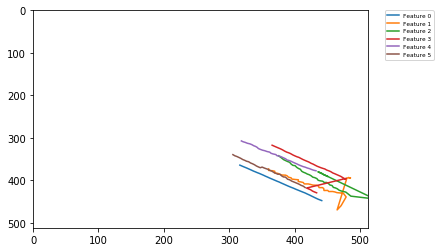

In [6]:
#Instantiate video
#file_path = "recordings/p1.avi"  # Change Me!
#cap = cv2.VideoCapture(file_path)

# Check that video is valid
old_frame = frames[0]
#if not ret:
#    raise Exception("No Frame")

    
# Create some random colors
color = np.random.randint(0,255,(100,3))

# GUI
def nothing(x):
    pass

gui = np.zeros((300,512,3), np.uint8)
cv2.namedWindow('gui')
switch = 'OFF-->ON'
cv2.createTrackbar(switch, 'gui',0,1,nothing)
cv2.createTrackbar('Winsize','gui',wSave,101,nothing)
cv2.createTrackbar('maxLevel','gui',mSave,10,nothing)
cv2.createTrackbar('criteria','gui',cSave,100,nothing)
cv2.createTrackbar('liveCutoff','gui',lSave,255,nothing)
cv2.createTrackbar('minDistance','gui',50,200,nothing)
cv2.createTrackbar('blockSize','gui',20,200,nothing)
cv2.createTrackbar('low','gui',100,255,nothing)
cv2.createTrackbar('high','gui',200,255,nothing)
s = 0

# Loop until switch is flipped
while(s<0.9):
    cv2.imshow('gui',gui)
    
    #Check for escape key
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

    # Grab current positions of track bars
    winS = cv2.getTrackbarPos('Winsize','gui')
    maxL = cv2.getTrackbarPos('maxLevel','gui')
    critNum = cv2.getTrackbarPos('criteria','gui')
    minD = cv2.getTrackbarPos('minDistance','gui')
    blockS = cv2.getTrackbarPos('blockSize','gui')
    low = cv2.getTrackbarPos('low','gui')
    high = cv2.getTrackbarPos('high','gui')
    liveCutoff = cv2.getTrackbarPos('liveCutoff','gui')
    s = cv2.getTrackbarPos(switch,'gui')

# Save values for next video
wSave = winS
mSave = maxL
cSave = critNum
lSave = liveCutoff

# Very important, always remember to close windows you aren't using
cv2.destroyAllWindows()

# /GUI

# Grab first frame and manual select features 
pos = []
count = 0
display_frame =  np.copy(old_frame)

# Mouse event for picking corners
def on_mouse_click(event, x, y, flags, frame):
    if event == cv2.EVENT_LBUTTONUP:
        global display_frame
        global count
        count += 1
        pos.append([y, x])
        display_frame = cv2.circle(display_frame,(x,y),5,color[count].tolist(),-1)

# Select corners for tracking until escape key pressed
while True:
        cv2.imshow('display_frame', display_frame)
        cv2.setMouseCallback('display_frame', on_mouse_click)
        s = cv2.waitKey(30) & 0xff
        if s == 27:
            time.sleep(1)
            break

# Parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 100, qualityLevel = 0.3, minDistance = minD,blockSize = blockS )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (winS,winS), maxLevel = maxL, criteria =
                 (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, critNum, 0.03))

# Take first frame and find corners in it
# Also make a mask

fgmask = None

old_gray = old_frame

p0 = cv2.goodFeaturesToTrack(old_gray, mask = fgmask, **feature_params)

# TODO: ALLOW MULTIPLE INPUT 

if len(pos) >= 1:
    for i, coords in enumerate(pos):
        if i == 0:
            p0 = np.array([[[float(coords[1]), float(coords[0])]]], np.float32)
        else: 
            p0 = np.vstack([p0, np.array([[[float(coords[1]+5), float(coords[0]+5)]]], np.float32)])

#p0 = [[[421, 133]], [[374, 86]]]
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

# Create empty arrays to track points
pointsList = [[np.array([]), np.array([])] for i in range(len(p0))]

for frame in frames[1:45]:
    frame_gray = frame
    th, old_gray = cv2.threshold(old_gray, liveCutoff, 255, cv2.THRESH_TOZERO_INV);
    th, frame_gray = cv2.threshold(frame_gray, liveCutoff, 255, cv2.THRESH_TOZERO_INV);
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    
    if p1 is None:
        break
    # pyrLK flow point selection/unroll
    good_new = p1[st==1]
    good_old = p0[st==1]
    for i in range(len(p1)):
        x = p1[i][0][0]
        y = p1[i][0][1]
        pointsList[i][0] = np.append(pointsList[i][0], x)
        pointsList[i][1] = np.append(pointsList[i][1], y)

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    
    # Original Frame
    img = cv2.add(frame,mask)
    # Black And White 
    #img = cv2.add(cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR),mask)
    
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # update frame/points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)


fig, ax = plt.subplots()
for i in range(len(pointsList)):
    ax.plot(*pointsList[i], label=("Feature " + str(i)))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='xx-small')
plt.axis([0,512,0,512])
plt.gca().invert_yaxis()
plt.show()

cv2.destroyAllWindows()